<a href="https://colab.research.google.com/github/messias-des-coden/trusted-anomaly-detection/blob/main/MAP_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from platform import python_version

print(python_version())


3.7.13


In [ ]:
pip install pyod

     |████████████████████████████████| 120 kB 26.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for pyod: filename=pyod-1.0.1-py3-none-any.whl size=147473 sha256=b056910296d495a842396ec60165245e9584b565235b1cd3dea3a74a1bc4d997
  Stored in directory: /root/.cache/pip/wheels/ea/c4/29/67ad87835b209f72e4706369c683741b09490f2829d64ea768
Successfully built pyod
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import numpy as np
import pickle
import statistics

#from xgboost import XGBClassifier
#from pandas import MultiIndex, Int64Index

#from sympy.core.numbers import igcd
from datetime import datetime

from sklearn import preprocessing
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler,QuantileTransformer,RobustScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
#from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import random
from scipy import stats


from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.xgbod import XGBOD
from pyod.models.cof import COF
from pyod.models.loda import LODA
from pyod.models.copod import COPOD
from pyod.models.sod import SOD
from pyod.models.vae import VAE
from pyod.models.lof import LocalOutlierFactor,LOF
from pyod.models.lscp import LSCP
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder


from keras.models import Sequential
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout,LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Flatten,Reshape,UpSampling1D
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.manifold import TSNE
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from numpy import NaN
from scipy.stats import chisquare
import statistics
#from art.metrics import clever_u, RobustnessVerificationTreeModelsCliqueMethod
#from art.estimators.classification import KerasClassifier
import tensorflow as tf
import tensorflow.keras.backend
#from art.estimators.classification import SklearnClassifier
#from art.attacks.evasion import FastGradientMethod, CarliniL2Method, DeepFool
from math import isclose
import re
from joblib import dump, load
import keras





/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tf.compat.v1.disable_eager_execution()


In [ ]:
#Generates the autoencoder 
def gen_autoencoder(X_train,encoding_dim):
    
    input_dim = X_train.shape[1] # the # features

    input_layer = Input(shape=(input_dim, ))
    hidden = Dense(encoding_dim[0], activation="relu")(input_layer)
    for n_neurons in encoding_dim[1:]:
        hidden = Dense(n_neurons, activation="relu")(hidden)#, activity_regularizer=regularizers.l1(10e-5))(input_layer)    
        #hidden = Dropout(0.5)(hidden)
    
    hidden = Dense(input_dim)(hidden)
    
    autoencoder = Model(inputs=input_layer, outputs=hidden)
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    autoencoder.compile(loss='mean_squared_error', optimizer = opt,metrics=['acc']) # TODO
    #autoencoder.compile(loss='categorical_crossentropy', optimizer = opt,metrics=['acc'])
    return autoencoder

#Get anomaly threshold from "autoencoder" setting the threshold in Q1,Q3+-1.5IQR
def get_threshold_mse_iqr(autoencoder,train_data):
    train_predicted = autoencoder.predict(train_data)
    mse = np.mean(np.power(train_data - train_predicted, 2), axis=1)
    iqr = np.quantile(mse,0.75) - np.quantile(mse, 0.25) # interquartile range
    up_bound = np.quantile(mse,0.75) + 1.5*iqr
    bottom_bound = np.quantile(mse,0.25) - 1.5*iqr
    thres = [up_bound,bottom_bound]
    return thres

#Get anomaly threshold from "autoencoder" setting the threshold in "train_data" using "outlier_percentage"
def get_threshold_mse_percentage(autoencoder,train_data,outlier_percentage):
    train_predicted = autoencoder.predict(train_data)
    mse = np.mean(np.power(train_data - train_predicted, 2), axis=1)
    thresh = np.quantile(mse, 1-outlier_percentage)
    return thresh

#Predict outliers in "df" using "autoencoder" model and "threshold_mse" as anomaly limit
def detect_outliers(autoencoder, df, threshold_mse):
    if(len(threshold_mse)==2):
        return detect_outliers_range(autoencoder, df, threshold_mse)
    pred=autoencoder.predict(df)
    mse = np.mean(np.power(df - pred, 2), axis=1)
    #plt.hist(mse, bins=100)
    #plt.show()
    outliers = [np.array(mse) < threshold_mse]
    return outliers

def detect_outliers_range(autoencoder, df, threshold_mse):
    pred=autoencoder.predict(df)
    mse = np.mean(np.power(df - pred, 2), axis=1)
    up_bound = threshold_mse[0]
    bottom_bound = threshold_mse[1]
    outliers = [(np.array(mse) < up_bound)&(np.array(mse) > bottom_bound)]
    return outliers
    

In [ ]:
def plot_hist(data):
    fig,ax = plt.subplots()
    fig.set_size_inches(10.5, 7.5, forward=True)
    plt.hist(data, bins = 1000)
    plt.show()

In [ ]:
# Data load
df_0=pd.read_csv("./Datasets/rp3_normal_0.csv") # "./Datasets/Rp3_3rd_capture/rp3_normal_all.csv
df_1=pd.read_csv("./Datasets/rp3_normal_1.csv")
df_2=pd.read_csv("./Datasets/rp3_normal_2.csv")
df_3=pd.read_csv("./Datasets/rp3_normal_3.csv")
df_4=pd.read_csv("./Datasets/rp3_normal_4.csv")
df_5=pd.read_csv("./Datasets/rp3_normal_5.csv")
df_6=pd.read_csv("./Datasets/rp3_normal_6.csv")
df_mix=pd.read_csv("./Datasets/rp3_normal_all.csv")

In [ ]:
# Filter vectors according to the timestamps

df_0 = df_0.loc[(df_0['timestamp'] >= 1615419435000) & (df_0['timestamp'] <= 1615451520000)]
df_1 = df_1.loc[(df_1['timestamp'] >= 1615925651000) & (df_1['timestamp'] <= 1615929569000)]
df_2 = df_2.loc[(df_2['timestamp'] >= 1615930017000) & (df_2['timestamp'] <= 1615933673000)]
df_3 = df_3.loc[(df_3['timestamp'] >= 1615969307000) & (df_3['timestamp'] <= 1615972800000)]
df_4 = df_4.loc[(df_4['timestamp'] >= 1615974874000) & (df_4['timestamp'] <= 1615978500000)]
df_5 = df_5.loc[(df_5['timestamp'] >= 1615978899000) & (df_5['timestamp'] <= 1615982700000)]
df_6 = df_6.loc[(df_6['timestamp'] >= 1615989015000) & (df_6['timestamp'] <= 1615992622000)]
df_mix = df_mix.loc[(df_mix['timestamp'] >= 1615996500000) & (df_mix['timestamp'] <= 1616005200000)]

In [ ]:
#df_0.describe()

In [ ]:
df = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_mix])
#df = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6])
#df= pd.concat([df_0, df_1, df_2, df_3, df_4])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5353 entries, 7 to 759
Data columns (total 82 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   time                                     5353 non-null   float64
 1   timestamp                                5353 non-null   int64  
 2   seconds                                  5353 non-null   float64
 3   connectivity                             5353 non-null   int64  
 4   alarmtimer:alarmtimer_fired              5353 non-null   int64  
 5   alarmtimer:alarmtimer_start              5353 non-null   int64  
 6   block:block_bio_backmerge                5353 non-null   int64  
 7   block:block_bio_remap                    5353 non-null   int64  
 8   block:block_dirty_buffer                 5353 non-null   int64  
 9   block:block_getrq                        5353 non-null   int64  
 10  block:block_touch_buffer                 5353 non

In [ ]:
df = df.loc[(df['connectivity']==1)]

In [ ]:
# Remove columns with constant values
df=df.loc[:, (df != df.iloc[0]).any()]

In [ ]:
df.describe()

,time,timestamp,seconds,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,block:block_touch_buffer,block:block_unplug,clk:clk_set_rate,...,writeback:sb_clear_inode_writeback,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written
count,5339.000000,5.339000e+03,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,...,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000
mean,3928.291767,1.615705e+12,5.011843,1.719798,2.635138,4.167634,0.907473,4.089530,0.504402,1.585690,...,1.074171,1.165574,54.862896,0.199850,3.126054,57.984079,0.995692,0.450272,0.233564,1.406443
std,3942.898974,2.698815e+08,0.009430,2.635422,3.840664,148.127538,1.395699,156.106611,0.772641,3.435362,...,1.885175,2.269565,181.420970,0.454724,143.379991,313.307298,0.089649,0.754349,0.649198,0.668851
min,15.033600,1.615419e+12,5.008997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,877.011500,1.615435e+12,5.010348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,1.000000
50%,1914.410000,1.615926e+12,5.010565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,21.000000,1.000000,0.000000,0.000000,1.000000
75%,6707.675000,1.615980e+12,5.011005,5.000000,7.000000,5.000000,2.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,26.000000,0.000000,0.000000,27.000000,1.000000,1.000000,0.000000,2.000000
max,13398.100000,1.616005e+12,5.285210,59.000000,72.000000,10521.000000,27.000000,11020.000000,24.000000,14.000000,...,7.000000,27.000000,11248.000000,6.000000,10448.000000,21697.000000,3.000000,8.000000,7.000000,4.000000


In [ ]:
df.drop(['time','timestamp'],axis=1,inplace=True)

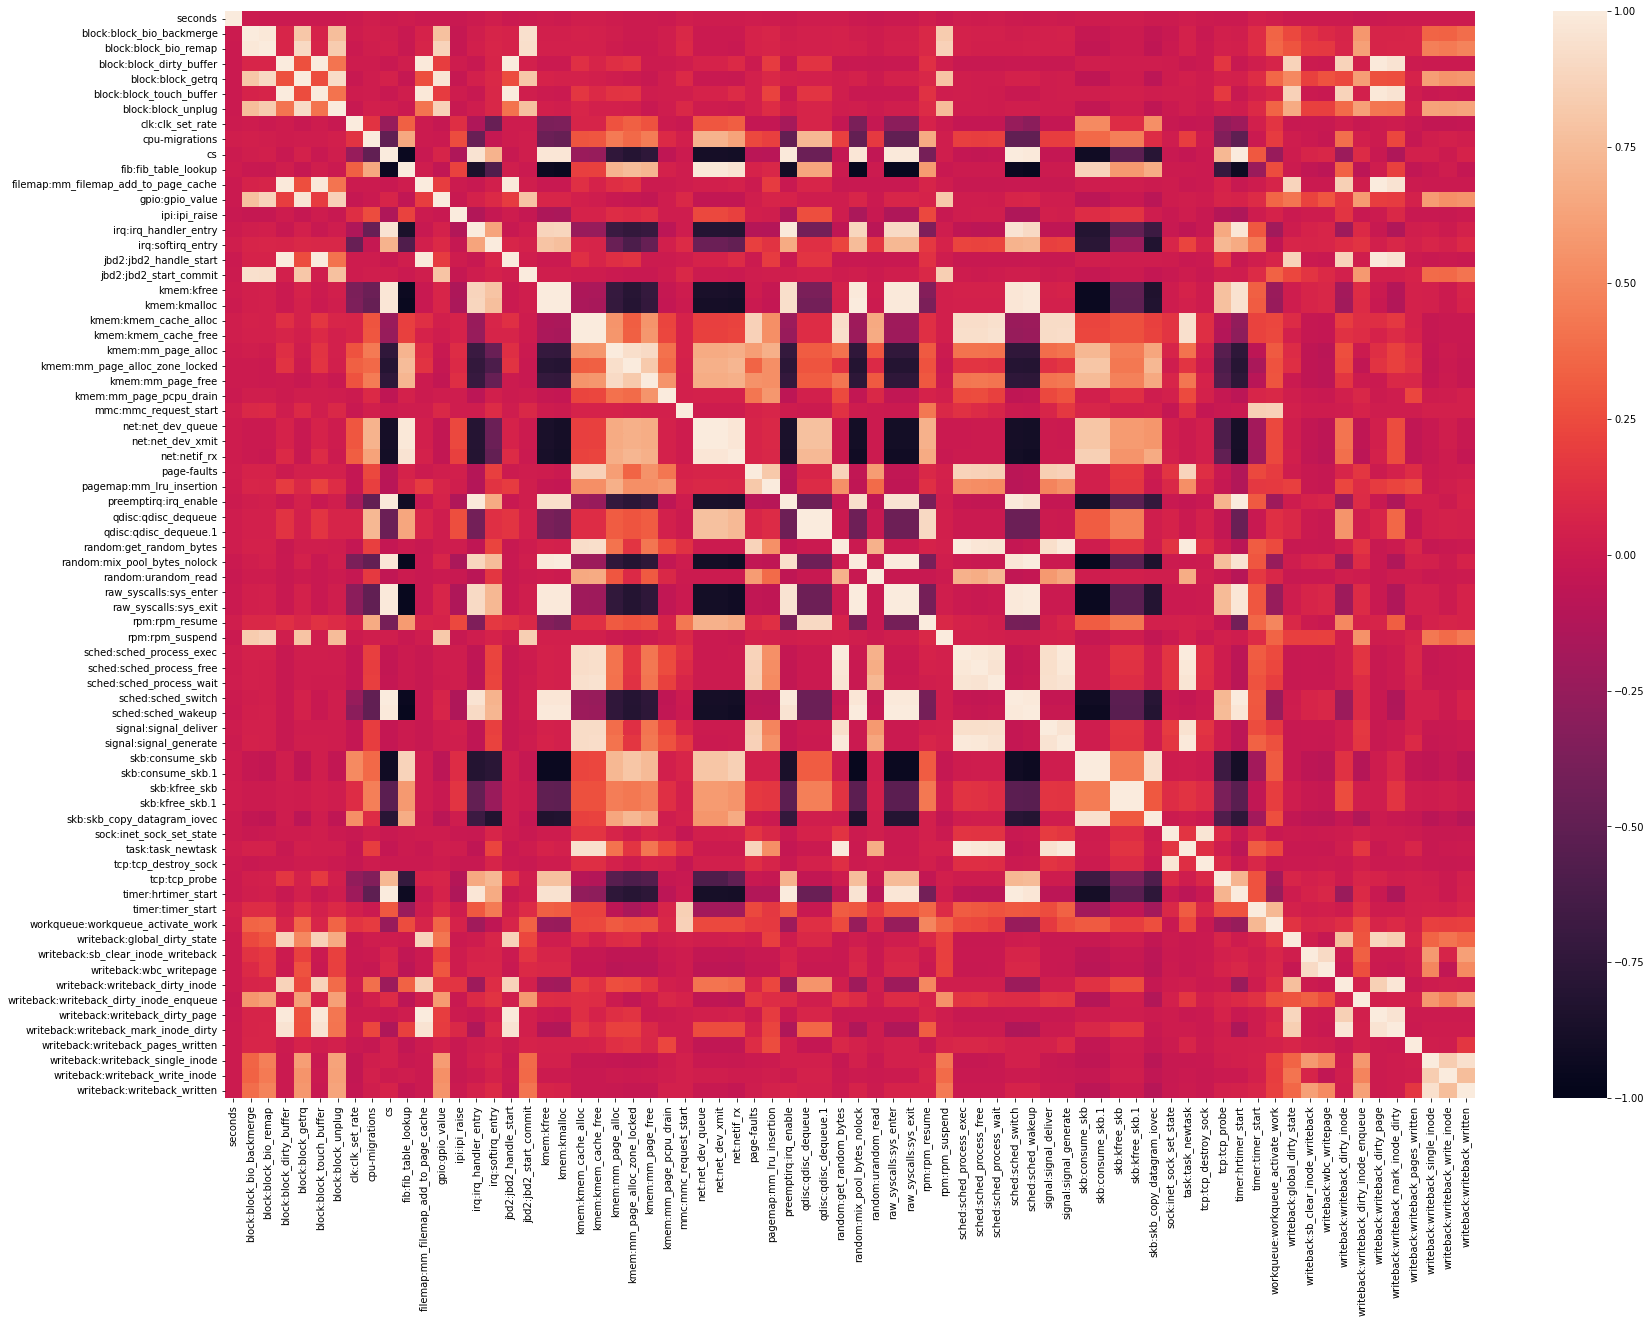

In [ ]:
# Calculate the correlation between features

corr = df.corr()
f, ax = plt.subplots(figsize=(28, 20))
sn.heatmap(corr,vmin=-1.0,vmax=1.0)

In [ ]:
# Split dataset in training, validation and testing
df_X_train, df_X_test = train_test_split(df, test_size=0.10, random_state=42)
df_X_val, df_X_test = train_test_split(df_X_test, test_size=0.50, random_state=42)

In [ ]:
#Save selected features
feat_list=df_X_train.columns

In [ ]:
#Feature scaling

# Min_Max_Scaler normalization
#scaler = MinMaxScaler().fit(X_train)
#scaler = QuantileTransformer(n_quantiles=1000,random_state=42).fit(X_train)
#scaler = RobustScaler().fit(X_train)
scaler= StandardScaler().fit(df_X_train)

# Transform training set
X_train = scaler.transform(df_X_train)

# Transform validation set
X_val = scaler.transform(df_X_val)
#TODO

# Transform test set
X_test = scaler.transform(df_X_test)

In [ ]:
# Different models

#clf = IsolationForest(random_state=42, contamination=0.2)
"""detector_list=[AutoEncoder([32,16,32], hidden_activation='relu',epochs=20,contamination=0.1),
                LOF(contamination=0.1,n_neighbors=25), COPOD(contamination=0.1),
                IForest(random_state=42,contamination=0.1), CBLOF(n_clusters=20,contamination=0.1),
                HBOS(n_bins=100,contamination=0.1), LODA(n_bins=100,n_random_cuts=100,contamination=0.1)]"""
#clf = LSCP(detector_list)
#clf = AutoEncoder([16], hidden_activation='relu',epochs=20,contamination=0.2,dropout_rate=0.0,preprocessing=True)
#clf = LOF(contamination=0.05,n_neighbors=50, novelty=True)
#clf = CBLOF(n_clusters=20,contamination=0.2)
#clf = VAE(encoder_neurons=[32,16],decoder_neurons=[16,32],latent_dim=2,epochs=50,contamination=0.05,verbose=1)
#clf = LODA(n_bins=100,n_random_cuts=100,contamination=0.2)
#clf = COPOD(contamination=0.2)
#clf = HBOS(n_bins=100,contamination=0.2)
#clf = SO_GAAL(contamination=0.2)
#clf = MO_GAAL(contamination=0.2)
#clf = OCSVM(kernel='rbf',gamma=0.0001, nu=0.3)


"detector_list=[AutoEncoder([32,16,32], hidden_activation='relu',epochs=20,contamination=0.1),\n                LOF(contamination=0.1,n_neighbors=25), COPOD(contamination=0.1),\n                IForest(random_state=42,contamination=0.1), CBLOF(n_clusters=20,contamination=0.1),\n                HBOS(n_bins=100,contamination=0.1), LODA(n_bins=100,n_random_cuts=100,contamination=0.1)]"

In [ ]:
classifiers = {
    "clf_IF": IsolationForest(random_state=42, contamination=0.2),
    #"clf_LSCP": LSCP(detector_list),
    "clf_AE": AutoEncoder([16], hidden_activation='relu',epochs=20,contamination=0.2,dropout_rate=0.0,preprocessing=True),
    "clf_LOF": LOF(contamination=0.05,n_neighbors=50, novelty=True), #TODO novelty
    "clf_CBLOF": CBLOF(n_clusters=20,contamination=0.2),
    #"clf_VAE": VAE(encoder_neurons=[32,16],decoder_neurons=[16,32],latent_dim=2,epochs=50,contamination=0.05,verbose=1), #TODO
    "clf_LODA": LODA(n_bins=100,n_random_cuts=100,contamination=0.2),
    "clf_COPOD": COPOD(contamination=0.2),
    "clf_HBOS": HBOS(n_bins=100,contamination=0.2),
    "clf_SO_GAAL": SO_GAAL(contamination=0.2),
    "clf_MO_GAAL": MO_GAAL(contamination=0.2),
    "clf_OCSVM": OCSVM(kernel='rbf',gamma=0.0001, nu=0.3),
}


In [ ]:
# Model training
#clf.fit(X_train)

# save the model
#dump(clf, 'clf_IF.joblib')

# load the model
#clf = load('clf_IF.joblib')

'''
for clf_name, clf in classifiers.items():
  clf.fit(X_train)
  dump(clf, clf_name + ".joblib")
'''


for clf_name, clf in classifiers.items():
  print(load(clf_name + ".joblib"))


IsolationForest(contamination=0.2, random_state=42)
AutoEncoder(batch_size=32, contamination=0.2, dropout_rate=0.0, epochs=20,
      hidden_activation='relu', hidden_neurons=[16], l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7efec3d2a050>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)
LOF(algorithm='auto', contamination=0.05, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=50, novelty=True, p=2)
CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.2, n_clusters=20, n_jobs=None, random_state=None,
   use_weights=False)
LODA(contamination=0.2, n_bins=100, n_random_cuts=100)
COPOD(contamination=0.2, n_jobs=1)
HBOS(alpha=0.1, contamination=0.2, n_bins=100, tol=0.5)
SO_GAAL(contamination=0.2, decay=1e-06, lr_d=0.01, lr_g=0.0001, momentum=0.9,
    stop_epochs=20)
MO_GAAL(contamination=0.2, decay=1e-06, k=10, lr_d=0.01, 

In [ ]:
# Model evaluation with good behaviour
'''
pred=clf.predict(X_test)
unique_elements, counts_elements = np.unique(pred, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)
'''

'\npred=clf.predict(X_test)\nunique_elements, counts_elements = np.unique(pred, return_counts=True)\nprint("\t",unique_elements,"    ",counts_elements)\n'

In [ ]:
'''
for clf_name, clf in classifiers.items():
  print(clf_name)
  clf = load(clf_name + ".joblib")
  pred = clf.predict(X_test)
  unique_elements, counts_elements = np.unique(pred, return_counts=True)
  print("\t",unique_elements,"    ",counts_elements)
  if isinstance(clf, IsolationForest):
    print(compute_accuracy(unique_elements, counts_elements, -1, 1))
  else:
    print(compute_accuracy(unique_elements, counts_elements, 1, 0))
'''

'\nfor clf_name, clf in classifiers.items():\n  print(clf_name)\n  clf = load(clf_name + ".joblib")\n  pred = clf.predict(X_test)\n  unique_elements, counts_elements = np.unique(pred, return_counts=True)\n  print("\t",unique_elements,"    ",counts_elements)\n  if isinstance(clf, IsolationForest):\n    print(compute_accuracy(unique_elements, counts_elements, -1, 1))\n  else:\n    print(compute_accuracy(unique_elements, counts_elements, 1, 0))\n'

In [ ]:
#MANUAL AUTOENCODER BUILD AND TRAIN
autoencoder=gen_autoencoder(X_train,[32,16,32])
es = EarlyStopping(monitor='val_loss', mode='min',patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
history = autoencoder.fit(X_train, X_train,epochs=2000,
                    batch_size=16,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es, mc]).history
autoencoder = load_model('best_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train on 3844 samples, validate on 961 samples
Epoch 1/2000
3840/3844 [============================>.] - ETA: 0s - loss: 0.6373 - acc: 0.0198

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


3844/3844 [==============================] - 2s 566us/sample - loss: 0.6376 - acc: 0.0198 - val_loss: 0.3386 - val_acc: 0.0375
Epoch 2/2000
3844/3844 [==============================] - 1s 220us/sample - loss: 0.4053 - acc: 0.0552 - val_loss: 0.2503 - val_acc: 0.0728
Epoch 3/2000
3844/3844 [==============================] - 1s 279us/sample - loss: 0.3235 - acc: 0.1116 - val_loss: 0.1991 - val_acc: 0.1769
Epoch 4/2000
3844/3844 [==============================] - 1s 248us/sample - loss: 0.2707 - acc: 0.2466 - val_loss: 0.1807 - val_acc: 0.2352
Epoch 5/2000
3844/3844 [==============================] - 1s 292us/sample - loss: 0.2230 - acc: 0.3187 - val_loss: 0.1610 - val_acc: 0.3757
Epoch 6/2000
3844/3844 [==============================] - 1s 249us/sample - loss: 0.1843 - acc: 0.3738 - val_loss: 0.1592 - val_acc: 0.3736
Epoch 7/2000
3844/3844 [==============================] - 1s 224us/sample - loss: 0.1787 - acc: 0.4004 - val_loss: 0.1269 - val_acc: 0.4620
Epoch 8/2000
3844/3844 [=========

In [ ]:
train_predicted = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - train_predicted, 2), axis=1)

print(mse)
print(np.quantile(mse,0.75))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[0.01288696 0.00767411 0.00964633 ... 0.03986706 0.00732208 0.01282809]
0.01995959635398266


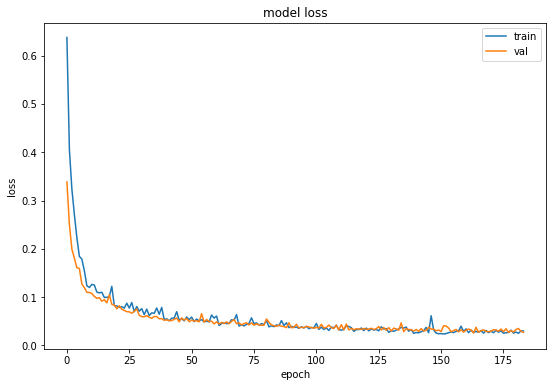

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
#GET ANOMALY THRESHOLD
#autoencoder = load_model('best_model.h5')
#thresh = get_threshold_mse_percentage(autoencoder,X_train,0.1)
thresh = get_threshold_mse_iqr(autoencoder,X_train)
print(thresh)

[0.03947049558438026, -0.012558569030013345]


In [ ]:
# Predict Anomalies contained in the normal behaviour
mad_outliers = detect_outliers(autoencoder, X_test, thresh)
print(mad_outliers)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True

In [ ]:
##### Attack 1: SENDING FAKE PSD VALUES ####

In [ ]:
df_fakepsd=pd.read_csv("./Datasets/rp3_fakePSD.csv")

In [ ]:
df_fakepsd_1 = df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615452439000) & (df_fakepsd['timestamp'] <= 1615478400000)]
df_fakepsd_2 = df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615479600000) & (df_fakepsd['timestamp'] <= 1615485600000)]

df_fakepsd = pd.concat([df_fakepsd_1, df_fakepsd_2])
df_fakepsd.drop(['time','timestamp'],axis=1,inplace=True)

In [ ]:
df_fakepsd = df_fakepsd.loc[(df_fakepsd['connectivity']==1)]

In [ ]:
df_fakepsd = df_fakepsd[df_fakepsd.columns.intersection(feat_list)]

In [ ]:
print(len(df_fakepsd.columns))

72


In [ ]:
df_fakepsd = scaler.transform(df_fakepsd)

In [ ]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [ ]:
mad_outliers = detect_outliers(autoencoder, df_fakepsd, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [2679]


In [ ]:
##### Attack 2: SENDING OUT PSD VALUES #### 

In [ ]:
df_sendout=pd.read_csv("./Datasets/rp3_sendOut.csv")

In [ ]:
df_sendout_1 = df_sendout.loc[(df_sendout['timestamp'] >= 1615795500000) & (df_sendout['timestamp'] <= 1615805280000)]
df_sendout_2 = df_sendout.loc[(df_sendout['timestamp'] >= 1615806000000) & (df_sendout['timestamp'] <= 1615809600000)]

df_sendout = pd.concat([df_sendout_1, df_sendout_2])
df_sendout.drop(['time','timestamp'],axis=1,inplace=True)

In [ ]:
df_sendout = df_sendout.loc[(df_sendout['connectivity']==1)]

In [ ]:
df_sendout = df_sendout[df_sendout.columns.intersection(feat_list)]

In [ ]:
df_sendout = scaler.transform(df_sendout)

In [ ]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [ ]:
mad_outliers = detect_outliers(autoencoder, df_sendout, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [1122]


In [ ]:
##### Attack 3: WRITE #### PRIVACY LEAKAGE

In [ ]:
df_write=pd.read_csv("./Datasets/rp3_write.csv")

In [ ]:
df_write = df_write.loc[(df_write['timestamp'] >= 1615834554000) & (df_write['timestamp'] <= 1615843200000)]

df_write.drop(['time','timestamp'],axis=1,inplace=True)

In [ ]:
df_write = df_write.loc[(df_write['connectivity']==1)]

In [ ]:
df_write = df_write[df_write.columns.intersection(feat_list)]

In [ ]:
df_write = scaler.transform(df_write)

In [ ]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [ ]:
mad_outliers = detect_outliers(autoencoder, df_write, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [708]


In [ ]:
##### Attack 4: ADDING RANDOM NOISE TO PSD VALUES ####

In [ ]:
# Data load
df_random=pd.read_csv("./Datasets/rp3_random.csv")

In [ ]:
# Remove columns with constant values
df_random = df_random.loc[(df_random['connectivity']==1)]

In [ ]:
# Filter vectors according to the timestamps
df_random_new = df_random.loc[(df_random['timestamp'] >= 1615913848000) & (df_random['timestamp'] <= 1615922405000)]

df_random_new.drop(['time','timestamp'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_outliers6=df_random_new[df_random_new.columns.intersection(feat_list)]

In [ ]:
# Transform outliers set
X_outliers6 = scaler.transform(X_outliers6)

In [ ]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers6, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [717]


In [ ]:
##### Attack 5: EXCHANGE PSD VALUES OF TWO FREQUENCY BANDS ####
# Freq bands 90Mhz - [300Mhz - 1Ghz]

In [ ]:
# Data load
df_exchange2=pd.read_csv("./Datasets/rp3_exchange.csv")

In [ ]:
# Remove columns with constant values
df_exchange2 = df_exchange2.loc[(df_exchange2['connectivity']==1)]

In [ ]:
# Filter vectors according to the timestamps
df_exchange2 = df_exchange2.loc[(df_exchange2['timestamp'] >= 1616585145000) & (df_exchange2['timestamp'] <= 1616589463000)]

df_exchange2.drop(['time','timestamp'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_outliers9=df_exchange2[df_exchange2.columns.intersection(feat_list)]

In [ ]:
# Transform outliers set
X_outliers9 = scaler.transform(X_outliers9)

In [ ]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers9, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False  True]      [228 119]


In [ ]:
##### Attack 6: Hide a transmission ####
# 200Mhz - 250Mz

In [ ]:
# Data load
df_hide=pd.read_csv("./Datasets/rp3_hide.csv")

In [ ]:
# Remove columns with constant values
df_hide = df_hide.loc[(df_hide['connectivity']==1)]

In [ ]:
# Filter vectors according to the timestamps
df_hide = df_hide.loc[(df_hide['timestamp'] >= 1616672277000) & (df_hide['timestamp'] <= 1616676574000)]

df_hide.drop(['time','timestamp'],axis=1,inplace=True)

In [ ]:
X_outliers10 = df_hide[df_hide.columns.intersection(feat_list)]

In [ ]:
# Transform outliers set
X_outliers10 = scaler.transform(X_outliers10)

In [ ]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers10, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False  True]      [ 43 312]


In [ ]:
##################
#### Fairness ####
##################

In [ ]:
factsheet = {
    "general": {
        "model_name": "Melike's Neural Network",
        "purpose_description": "Attack Classification",
        "domain_description": "IT Security",
        "training_data_description": "Alberto's classification data",
        "model_information": "Keras Neural Network Classifier for IT Security Incident Classification scenario",
        # "target_column": "label",
        "authors": "Melike Demirci",
        "contact_information": "melike.demirci@uzh.ch"
    },
    "fairness": {
        "protected_feature": "writeback:writeback_dirty_inode_enqueue",
        "protected_values": [
            1
        ],
        # "favorable_outcomes": [13]
    },
    "methodology": {
        "regularization": "none"
    },
    "scores": {
        "fairness": {
            "underfitting": NaN,
            "overfitting": NaN,
            "statistical_parity_difference": NaN,
            "equal_opportunity_difference": NaN,
            "average_odds_difference": NaN,
            "disparate_impact": NaN,
            "class_balance": 5
        },
        "explainability": {
            "algorithm_class": 1,
            "correlated_features": 2,
            "model_size": 2,
            "feature_relevance": NaN
        },
        "robustness": {
            "confidence_score": NaN,
            "clique_method": NaN,
            "loss_sensitivity": 2,
            "clever_score": 4,
            "er_fast_gradient_attack": NaN,
            "er_carlini_wagner_attack": NaN,
            "er_deepfool_attack": NaN
        },
        "methodology": {
            "normalization": 4,
            "missing_data": 5,
            "regularization": 1,
            "train_test_split": 5,
            "factsheet_completeness": 5
        }
    },
    "properties": {
        "fairness": {
            "underfitting": {
                "Non computable because": "name 'X_train' is not defined"
            },
            "overfitting": {
                "Non computable because": "name 'X_train' is not defined"
            },
            "statistical_parity_difference": {
                "Non computable because": "division by zero"
            },
            "equal_opportunity_difference": {
                "Non computable because": "division by zero"
            },
            "average_odds_difference": {
                "Non computable because": "division by zero"
            },
            "disparate_impact": {
                "Non computable because": "division by zero"
            },
            "class_balance": {
                "Metric Description": "Measures how well the training data is balanced or unbalanced",
                "Depends on": "Training Data",
                "Score": "5"
            }
        },
        "explainability": {
            "algorithm_class": {
                "dep": [
                    "Depends on",
                    "Model"
                ],
                "clf_name": [
                    "model type",
                    "Sequential"
                ]
            },
            "correlated_features": {
                "dep": [
                    "Depends on",
                    "Training Data"
                ],
                "pct_drop": [
                    "Percentage of highly correlated features",
                    "39.73%"
                ]
            },
            "model_size": {
                "dep": [
                    "Depends on",
                    "Training Data"
                ],
                "n_features": [
                    "number of features",
                    73
                ]
            },
            "feature_relevance": {
                "dep": [
                    "Depends on",
                    "Training Data and Model"
                ]
            }
        },
        "robustness": {
            "confidence_score": {
                "non_computable": [
                    "Non Computable Because",
                    "Can only be calculated on models which provide prediction probabilities."
                ]
            },
            "clique_method": {
                "non_computable": [
                    "Non Computable Because",
                    "Can only be calculated on Tree-Based models."
                ]
            },
            "loss_sensitivity": {
                "loss_sensitivity": [
                    "Average gradient value of the loss function",
                    "1.54"
                ],
                "depends_on": [
                    "Depends on",
                    "Model"
                ]
            },
            "clever_score": {
                "clever_score": [
                    "CLEVER Score",
                    "1.04"
                ],
                "depends_on": [
                    "Depends on",
                    "Model"
                ]
            },
            "er_fast_gradient_attack": {
                "non_computable": [
                    "Non Computable Because",
                    "Can be calculated on either SVC or Logistic Regression models."
                ]
            },
            "er_carlini_wagner_attack": {
                "non_computable": [
                    "Non Computable Because",
                    "Can be calculated on either SVC or Logistic Regression models."
                ]
            },
            "er_deepfool_attack": {
                "non_computable": [
                    "Non Computable Because",
                    "Can be calculated on either SVC or Logistic Regression models."
                ]
            }
        },
        "methodology": {
            "normalization": {
                "dep": [
                    "Depends on",
                    "Training and Testing Data"
                ],
                "Training_mean": [
                    "Mean of the training data",
                    "-0.00"
                ],
                "Training_std": [
                    "Standard deviation of the training data",
                    "1.00"
                ],
                "Test_mean": [
                    "Mean of the test data",
                    "-0.03"
                ],
                "Test_std": [
                    "Standard deviation of the test data",
                    "0.88"
                ],
                "normalization": [
                    "Normalization",
                    "Training data are standardized"
                ]
            },
            "missing_data": {
                "dep": [
                    "Depends on",
                    "Training Data"
                ],
                "null_values": [
                    "Number of the null values",
                    "0"
                ]
            },
            "regularization": {
                "dep": [
                    "Depends on",
                    "Factsheet"
                ],
                "regularization_technique": [
                    "Regularization technique",
                    "none"
                ]
            },
            "train_test_split": {
                "dep": [
                    "Depends on",
                    "Training and Testing Data"
                ],
                "train_test_split": [
                    "Train test split",
                    "80.00/20.00"
                ]
            },
            "factsheet_completeness": {
                "dep": [
                    "Depends on",
                    "Factsheet"
                ],
                "model_name": [
                    "Factsheet Property model name",
                    "present"
                ],
                "purpose_description": [
                    "Factsheet Property purpose description",
                    "present"
                ],
                "domain_description": [
                    "Factsheet Property domain description",
                    "present"
                ],
                "training_data_description": [
                    "Factsheet Property training data description",
                    "present"
                ],
                "model_information": [
                    "Factsheet Property model information",
                    "present"
                ],
                "target_column": [
                    "Factsheet Property target column",
                    "present"
                ],
                "authors": [
                    "Factsheet Property authors",
                    "present"
                ],
                "contact_information": [
                    "Factsheet Property contact information",
                    "present"
                ]
            }
        }
    }
}

In [ ]:
mappings = {
    "fairness": {
        "score_underfitting": {
            "thresholds": {
                "value": [
                    0.8,
                    0.85,
                    0.9,
                    0.95
                ],
                "description": "",
                "label": ""
            }
        },
        "score_overfitting": {
            "thresholds": {
                "value": [
                    0.04,
                    0.03,
                    0.02,
                    0.01,
                    0
                ],
                "description": "",
                "label": ""
            }
        },
        "score_statistical_parity_difference": {
            "thresholds": {
                "value": [
                    0.075,
                    0.05,
                    0.025,
                    0.01,
                    0
                ],
                "description": "",
                "label": ""
            }
        },
        "score_equal_opportunity_difference": {
            "thresholds": {
                "value": [
                    0.15,
                    0.1,
                    0.05,
                    0.03,
                    0
                ],
                "description": "",
                "label": ""
            }
        },
        "score_average_odds_difference": {
            "thresholds": {
                "value": [
                    0.15,
                    0.1,
                    0.05,
                    0.03,
                    0
                ],
                "description": "",
                "label": ""
            }
        },
        "score_disparate_impact": {
            "thresholds": {
                "value": [
                    0.8,
                    0.85,
                    0.9,
                    0.95
                ],
                "description": "",
                "label": ""
            }
        }
    },
    "explainability": {
        "score_algorithm_class": {
            "clf_type_score": {
                "value": {
                    "RandomForestClassifier": 4,
                    "KNeighborsClassifier": 3,
                    "SVC": 2,
                    "GaussianProcessClassifier": 3,
                    "DecisionTreeClassifier": 5,
                    "MLPClassifier": 1,
                    "AdaBoostClassifier": 3,
                    "GaussianNB": 3.5,
                    "QuadraticDiscriminantAnalysis": 3,
                    "LogisticRegression": 4,
                    "LinearRegression": 3.5,
                    "Sequential": 1
                },
                "description": "Mapping of Learning techniques to the level of explainability based on on literature research and qualitative analysis of each learning technique. For more information see gh-pages/explainability/taxonomy",
                "label": "Score Mapping"
            }
        },
        "score_model_size": {
            "thresholds": {
                "value": [
                    10,
                    25,
                    50,
                    100
                ],
                "description": "Thresholds of how to map model size to a score from 1-5. Example if 10 is the first number it means that a model with 10 or less features would get the best score(5) and if 500 was the last number it would mean that a model with 500 or more features would get the worst score (1), analog for the numbers in between",
                "label": "Score Thresholds"
            }
        },
        "score_correlated_features": {
            "high_cor": {
                "value": 0.95,
                "description": "Threshold value to classify a correlation as highly correlated. Default value is 0.95 meaning every correlation equal or higher than 0.9 would be considered highly correlated",
                "label": "High Correlation Threshold"
            },
            "thresholds": {
                "value": [
                    0.05,
                    0.15,
                    0.25,
                    0.4
                ],
                "description": "Thresholds of how to map the percentage of highly correlated features (>= high_cor or default 0.9) to a score from 1-5. Example if 0.05 is the first number it means that training dataset with 5% or less highly correlated variables would get the best score(5) and if 0.4 was the last number it would mean that a training dataset 40% or more highly correlated features would get the worst score (1), analog for the numbers in between",
                "label": "Score Thresholds"
            }
        },
        "score_feature_relevance": {
            "thresholds": {
                "value": [
                    0.05,
                    0.1,
                    0.15,
                    0.2
                ],
                "description": "Map the fraction of many features make up 60% of all importance to a Score from 1-5. If the first number in the list is 0.05 it means that 5% or less features make up more than 60% of all importance, which would be a very skewed distribution of the feature importance and result in the worst score of 1, and if the next number is 0.1 it means if the fraction is between 5%-10% the Score would be a 2, analog the other thresholds",
                "label": "Score Thresholds"
            },
            "threshold_outlier": {
                "value": 0.03,
                "description": "The threshold for a score penalty if there are too many outliers in the feature importance distribution. For example if the threshold is 0.03 it means taht if 3% or more features are outliers a penalty with tha value #penalty_outlier would be substacted from the score",
                "label": "Threshold for outliers"
            },
            "penalty_outlier": {
                "value": 0,
                "description": "The penalty that should be applied if the the number of outliers in the feature importance distribution is equal or greater than the #threshold_outlier. For example if this value is 0.5 it would mean if the the theshold is reached 0.5 points will be substacted from score. If the number is set to 0 no penalty will be applied",
                "label": "Penalty for outliers"
            }
        }
    },
    "robustness": {
        "score_clique_method": {
            "thresholds": {
                "value": [
                    0.01,
                    0.1,
                    0.25,
                    0.5
                ],
                "description": "Thresholds of how to map the result of the clique method from 1-5.",
                "label": "Score Thresholds"
            }
        },
        "score_loss_sensitivity": {
            "thresholds": {
                "value": [
                    2,
                    1.5,
                    1,
                    0.5
                ],
                "description": "Thresholds of how to map loss sensitivity from 1-5. Smaller value means higher robustness.",
                "label": "Score Thresholds"
            }
        },
        "score_clever_score": {
            "thresholds": {
                "value": [
                    0.2,
                    0.5,
                    1,
                    2.5
                ],
                "description": "Thresholds of how to map CLEVER score from 1-5.",
                "label": "Score Thresholds"
            }
        },
        "score_confidence_score": {
            "thresholds": {
                "value": [
                    20,
                    40,
                    60,
                    80
                ],
                "description": "Thresholds of how to map confidence score from 1-5. Better confidence score means higher robustness.",
                "label": "Score Thresholds"
            }
        },
        "score_fast_gradient_attack": {
            "thresholds": {
                "value": [
                    80,
                    60,
                    40,
                    20
                ],
                "description": "Thresholds of how to map difference between before-after attack accuracies from 1-5. Example: If the before attack accuracy is 85% and after attack accuracy is again 85% it means model is so robust that attack was not successful at all. The difference is 0 and hence this would result in a score of 5 (best score). However if the before attack accuracy was 100% and after attack accuracy is 0% then the model is not robust. The difference is 100% and it would result in score 0 (worst score)",
                "label": "Score Thresholds"
            }
        },
        "score_carlini_wagner_attack": {
            "thresholds": {
                "value": [
                    80,
                    60,
                    40,
                    20
                ],
                "description": "Thresholds of how to map difference between before-after attack accuracies from 1-5. Example: If the before attack accuracy is 85% and after attack accuracy is again 85% it means model is so robust that attack was not successful at all. The difference is 0 and hence this would result in a score of 5 (best score). However if the before attack accuracy was 100% and after attack accuracy is 0% then the model is not robust. The difference is 100% and it would result in score 0 (worst score)",
                "label": "Score Thresholds"
            }
        },
        "score_deepfool_attack": {
            "thresholds": {
                "value": [
                    80,
                    60,
                    40,
                    20
                ],
                "description": "Thresholds of how to map difference between before-after attack accuracies from 1-5. Example: If the before attack accuracy is 85% and after attack accuracy is again 85% it means model is so robust that attack was not successful at all. The difference is 0 and hence this would result in a score of 5 (best score). However if the before attack accuracy was 100% and after attack accuracy is 0% then the model is not robust. The difference is 100% and it would result in score 0 (worst score)",
                "label": "Score Thresholds"
            }
        }
    },
    "methodology": {
        "score_normalization": {
            "mappings": {
                "value": {
                    "None": 1,
                    "training_normal": 2,
                    "training_and_test_normal": 3,
                    "training_standardized": 4,
                    "training_and_test_standardize": 5
                },
                "description": "Dictionary of how to map different normalization types to scores between 1-5.",
                "label": "Score Thresholds"
            }
        },
        "score_missing_data": {
            "mappings": {
                "value": {
                    "null_values_exist": 1,
                    "no_null_values": 5
                },
                "description": "Dictionary of how to map missing data to scores between 1-5.",
                "label": "Score Thresholds"
            }
        },
        "score_regularization": {
            "parameter_regularization_technique": {
                "value": "The value of the parameter_XY",
                "description": "The description of the paramter and its impact"
            }
        },
        "score_train_test_split": {
            "mappings": {
                "value": {
                    "50-60 95-97": 1,
                    "60-75 90-95": 2,
                    "70-75 85-90": 3,
                    "75-79 81-85": 4,
                    "79-81": 5
                },
                "description": "Thresholds of how to map the train-test split to a score between 1-5.",
                "label": "Score Thresholds"
            }
        },
        "score_factsheet_completeness": {
            "parameter_split": {
                "value": "The value of the parameter_XY",
                "description": "The description of the paramter and its impact"
            }
        }
    }
}

In [ ]:
### Helper methods

In [ ]:
def load_fairness_config(factsheet):
    message = ""
    protected_feature = factsheet.get("fairness", {}).get("protected_feature", '')
    if not protected_feature:
        message += "Definition of protected feature is missing."
        
    protected_values = factsheet.get("fairness", {}).get("protected_values", [])
    if not protected_values:
        message += "Definition of protected_values is missing."
    
    
    # not used for unsupervised
    '''
    target_column = factsheet.get("general", {}).get("target_column", '')
    if not target_column:
        message += "Definition of target column is missing."
        
    favorable_outcomes = factsheet.get("fairness", {}).get("favorable_outcomes", [])
    if not favorable_outcomes:
        message += "Definition of favorable outcomes is missing."
    '''
        
    if message:
        raise MissingFairnessDefinitionError(message) #TODO
    
    return protected_feature, protected_values

def compute_accuracy(unique_elements, counts_elements, outlier_indicator = False, normal_indicator = True):
    tot_datapoints = 0
    num_outliers = 0
    num_normal = 0      
    
    for i, el in enumerate(unique_elements):
        if el == normal_indicator:
            num_normal = counts_elements.item(i)
            tot_datapoints += num_normal
        if el == outlier_indicator:
            num_outliers = counts_elements.item(i)
            tot_datapoints += num_outliers

    if (tot_datapoints > 0):
      accuracy = num_outliers/tot_datapoints
    
    else:
      accuracy = 0

    return accuracy

def train_test_split_metric(training_dataset, test_dataset):
    n_train = len(training_dataset)
    n_test = len(test_dataset)
    n = n_train + n_test
    return round(n_train/n*100), round(n_test/n*100)

def regularization_metric(factsheet):
    if "methodology" in factsheet and "regularization" in factsheet["methodology"]:
        return factsheet["methodology"]["regularization"]
    else:
        return "NOT_SPECIFIED"

def isKerasAutoencoder(model):
    return isinstance(model, keras.engine.functional.Functional)

def isIsolationForest(model):
    return isinstance(model, IsolationForest)

def compute_outlier_ratio(model, data, outlier_thresh, print_details = False):
    if isKerasAutoencoder(model):
        mad_outliers = detect_outliers(model, data, outlier_thresh)
        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
        outlier_detection_percentage = compute_accuracy(unique_elements, counts_elements)

    elif isIsolationForest(model):
        mad_outliers = model.predict(data)
        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
        outlier_detection_percentage = compute_accuracy(unique_elements, counts_elements, -1, 1)
    
    else:
        mad_outliers = model.predict(data)
        unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
        outlier_detection_percentage = compute_accuracy(unique_elements, counts_elements, 1, 0)

    if print_details:
        print("\t uniqueelements: ", unique_elements)
        print("\t counts elements: ", counts_elements)

    return outlier_detection_percentage

    

In [ ]:
#### Accuracy

In [ ]:
def accuracy_score(model, outlier_data, outlier_thresh, score_thresh, print_details = False):
    """
    This function computes the accuracy score.
    

    Args:
        model: ML-model.
        outlier-data: numpy.ndarra outlier dataset. 
        outlier_thresh: list 
        score_thresholds: list

    Returns:
        1. Score

    """

    detected_outlier_ratio = compute_outlier_ratio(model, outlier_data, outlier_thresh, print_details)

    score = np.digitize(abs(detected_outlier_ratio), score_thresh, right=False) + 1 
    
    if print_details:
        print("\t detected outlier ratio: %.4f " % detected_outlier_ratio)
        
    return score

In [ ]:
#### Underfitting 

In [ ]:
def underfitting_score(model, train_data, outlier_percentage, outlier_thresh, score_thresh, print_details = False):
    # calculate train_data accuracy
   
    detected_outlier_ratio = compute_outlier_ratio(model, train_data, outlier_thresh)
    
    perc_diff = abs(outlier_percentage - detected_outlier_ratio)
    training_accuracy = (outlier_percentage-perc_diff)/outlier_percentage
    
    score = np.digitize(training_accuracy, score_thresh, right=False) + 1
    
    if print_details:
        print("\t model is AutoEncoder: ", isKerasAutoencoder(model))
        print("\t model is IsolationForest: ", isIsolationForest(model))
        print("\t unique_elements, counts_elements: ", unique_elements, counts_elements)
        print("\t outlier percentage in training data: ", outlier_percentage)
        print("\t detected outlier percentage: %.4f" % detected_outlier_ratio)
        print("\t training accuracy: %.4f" % training_accuracy)

    return score
    

In [ ]:
#### Overfitting 

In [ ]:
def overfitting_score(model, train_data, outlier_data, outlier_percentage, outlier_thresh, score_thresh, print_details = False):
    
    """
    This function computes the overfitting score.
    
    Args:
        model: ML-model.
        train_data: numpy.ndarray train dataset
        outlier-data: numpy.ndarray outlier dataset.
        outlier_percentage: float expected outlier percentage of the training_data
        outlier_thresh: list 
        score_thresholds: list

    Returns:
        1. Score

    """    
    underfit_score = underfitting_score(model, train_data, outlier_percentage, outlier_thresh, [0.80, 0.85, 0.90, 0.95], False)
    
    # calculate outlier accuracy
    if (underfit_score >= 3):
        # compute test accuracy
        test_accuracy = compute_outlier_ratio(model,outlier_data,outlier_thresh)

        # compute training accuracy
        outlier_detection_percentage = compute_outlier_ratio(model,train_data,outlier_thresh)  
        
        perc_diff = abs(outlier_percentage-outlier_detection_percentage)
        training_accuracy = (outlier_percentage-perc_diff)/outlier_percentage       
        accuracy_difference = abs(training_accuracy - test_accuracy)
        overfit_score = np.digitize(accuracy_difference, score_thresh, right=False) + 1
        
        if print_details:
            print("\t --compute training accuracy--")
            print("\t   outlier percentage in training data: ", outlier_percentage)
            print("\t   detected outlier percentage: %.4f" % outlier_detection_percentage)
            print("\t   training accuracy: %.4f" % training_accuracy)
            print("\t --compute test accuracy--")
            print("\t   test accuracy: %.4f" % test_accuracy)
            print("\t   train-test accuracy difference: %.4f" % accuracy_difference)

        return overfit_score
    
    return -1


In [ ]:
#### Statistical Parity Difference

In [ ]:
def statisical_parity_difference_score(model, df_train_data, scaler, protected_feature, protected_values, score_thresholds, print_details = False):

    """
    This function computes the statistical parity metric.
    It separates the data into a protected and an unprotected group 
    based on the given definition for protected groups.
    SPD is calculated as the spread between the percentage of observations 
    from the majority group receiving a favorable outcome compared to the protected group.

    Args:
        model: ML-model.
        df_train_dataset: pd.DataFrame training dataset on which the model was trained on. 
        protected_feature: string 
        protected_values: list of protected values.
        score_thresholds: list

    Returns:
        1. Score

    """
    
    df_train_data.reset_index(drop=True, inplace=True)
    X_train = scaler.transform(df_train_data)

    minority = df_train_data[df_train_data[protected_feature].isin(protected_values)]
    minority_size = len(minority)
    majority = df_train_data[~df_train_data[protected_feature].isin(protected_values)]
    majority_size = len(majority)
    
    if isKerasAutoencoder(model):
      thresh = get_threshold_mse_iqr(model, X_train)
      mad_outliers = detect_outliers(model, X_train, thresh)
      outlier_indices = [i for i, el in enumerate(mad_outliers[0].tolist()) if el == False]

    elif isIsolationForest(model):
      mad_outliers = model.predict(X_train)
      outlier_indices = [i for i, el in enumerate(mad_outliers.tolist()) if el == -1]

    else:
      mad_outliers = model.predict(X_train)
      outlier_indices = [i for i, el in enumerate(mad_outliers.tolist()) if el == 1]

    minority_indices = minority.index.tolist()
    majority_indices = majority.index.tolist()
        
    # measure num of outliers in majority group by intersection of indices
    num_outliers_minority = len(list(set(minority_indices) & set(outlier_indices)))
    num_outliers_majority = len(list(set(majority_indices) & set(outlier_indices)))
        
    favored_minority_ratio = num_outliers_minority/minority_size
    favored_majority_ratio = num_outliers_majority/majority_size

    statistical_parity_difference = abs(favored_minority_ratio - favored_majority_ratio)
    score = np.digitize(statistical_parity_difference, score_thresholds, right=False) + 1
    
    if print_details:
        print("\t protected feature: ", protected_feature)
        print("\t protected values: ", protected_values)
        print("\t group size: ", len(majority_indices), len(minority_indices))
        print("\t num outlier: ", num_outliers_majority, num_outliers_minority)
        print("\t outlier ratios: %.4f " %favored_majority_ratio, "%.4f " % favored_minority_ratio)
        print("\t statistical_parity_difference: %.4f" % statistical_parity_difference)
        
    return score




In [ ]:
#### Disparate Impact

In [ ]:
def disparate_impact_score(model, df_train_data, scaler, protected_feature, protected_values, score_thresholds, print_details = False):

    """
    This function computes the disparate impact metric.
    It separates the data into a protected and an unprotected group 
    based on the given definition for protected groups.
    Then it computes the ratio of the probability of outliers in the protected group
    divided by probability of outliers in the unprotected group.

    Args:
        model: ML-model.
        df_train_dataset: pd.DataFrame training dataset on which the model was trained on. 
        protected_feature: string 
        protected_values: list of protected values.
        score_thresholds: list

    Returns:
        1. Score

    """
    
    df_train_data.reset_index(drop=True, inplace=True)
    X_train = scaler.transform(df_train_data)

    minority = df_train_data[df_train_data[protected_feature].isin(protected_values)]
    minority_size = len(minority)
    majority = df_train_data[~df_train_data[protected_feature].isin(protected_values)]
    majority_size = len(majority)
    
    if isKerasAutoencoder(model):
      thresh = get_threshold_mse_iqr(model, X_train)
      mad_outliers = detect_outliers(model, X_train, thresh)
      outlier_indices = [i for i, el in enumerate(mad_outliers[0].tolist()) if el == False]

    elif isIsolationForest(model):
      mad_outliers = model.predict(X_train)
      outlier_indices = [i for i, el in enumerate(mad_outliers.tolist()) if el == -1]

    else:
      mad_outliers = model.predict(X_train)
      outlier_indices = [i for i, el in enumerate(mad_outliers.tolist()) if el == 1]

    minority_indices = minority.index.tolist()
    majority_indices = majority.index.tolist()
        
    # measure num of outliers in majority group by intersection of indices
    num_outliers_minority = len(list(set(minority_indices) & set(outlier_indices)))
    num_outliers_majority = len(list(set(majority_indices) & set(outlier_indices)))
        
    favored_minority_ratio = num_outliers_minority/minority_size
    favored_majority_ratio = num_outliers_majority/majority_size

    disparate_impact = abs(favored_minority_ratio/favored_majority_ratio)
    score = np.digitize(abs(disparate_impact), score_thresholds, right=False) + 1
    
    if print_details:
        print("\t protected feature: ", protected_feature)
        print("\t protected values: ", protected_values)
        print("\t group size: ", len(majority_indices), len(minority_indices))
        print("\t num outlier: ", num_outliers_majority, num_outliers_minority)
        print("\t outlier ratios: %.4f " %favored_majority_ratio, "%.4f " % favored_minority_ratio)
        print("\t disparate_impact: %.4f" % disparate_impact)
        
    return score

In [ ]:
#### Class Balance

In [ ]:
def class_balance_score(df_train_data, target_column, significance_level, print_details = False):

    """
    This function computes the class balance metric.

    Args:
        df_train_dataset: pd.DataFrame training dataset on which the model was trained on.
        significance_level: float
        target_column: string

    Returns:
        1. Score

    """
    absolute_class_occurences = df_train_data[target_column].value_counts().sort_index().to_numpy()

    p_value = chisquare(absolute_class_occurences, ddof=0, axis=0).pvalue
    if p_value < significance_level:
        score = 1
    else:
        score = 5
    
    if print_details:
        print("\t absolute class occurences: ", absolute_class_occurences)
        print("\t p value: %.4f" % p_value)
        
    return score

In [ ]:
########################
#### Explainability ####
########################

In [ ]:
#### Correlated Feature

In [ ]:
def correlated_features_score(train_data, test_data, thresholds=[0.05, 0.16, 0.28, 0.4], target_column=None, high_cor=0.9, print_details=False):
    
    test_data = test_data.copy()
    train_data = train_data.copy()
    
    df_comb = pd.concat([test_data, train_data])

    corr_matrix = df_comb.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    
    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > high_cor)]
    
    pct_drop = len(to_drop)/len(df_comb.columns)
    
    score = 5-np.digitize(pct_drop, thresholds, right=True) 
    
    if print_details:
        #print("\t to drop", to_drop)
        print("\t percentage drop: %.4f" % pct_drop)
    
    return score

In [ ]:
def model_size_score(test_data, thresholds = np.array([10,30,100,500]), print_details = False):
    
    score = 5- np.digitize(test_data.shape[1] , thresholds, right=True) 
    
    if print_details:
        print("\t num of features: ", test_data.shape[1])
         
    return score

In [ ]:
def permutation_feature_score(model, df_outliers_data, outlier_thresh, scaler, score_thresholds, print_details = False):
    #compute outlier detection without permutation
    scaled_outliers = scaler.transform(df_outliers_data)
    accuracy_no_permutation = compute_outlier_ratio(model,scaled_outliers,outlier_thresh, print_details)

    features = df_outliers_data.columns
    shuffles = 3
    feature_importance = {}
    num_redundant_feat = 0

    for feature in features:
        feature_importance[feature] = []  
        df_copy = df_outliers_data.copy()

        for _ in range(shuffles):
            #compute outlier detection with permutation
            df_copy[feature] = np.random.permutation(df_outliers_data[feature])
            scaled_outliers = scaler.transform(df_copy)
            accuracy_permutation = compute_outlier_ratio(model,scaled_outliers, outlier_thresh, print_details)

            diff = abs(accuracy_no_permutation-accuracy_permutation)
            feature_importance[feature].append(diff)  
            
        feature_importance[feature] = statistics.mean(feature_importance[feature])
        if (feature_importance[feature] == 0):
            num_redundant_feat += 1
            
    
    ratio_redundant_feat = num_redundant_feat/len(feature_importance)   
    feature_importance_desc = list(dict(sorted(feature_importance.items(), key=lambda item: item[1])).keys())[::-1]
    score = np.digitize(ratio_redundant_feat, score_thresholds, right=True)
    
    if print_details:
        print("\t num of redundant features: ", num_redundant_feat)
        print("\t percentage of redundant features: %.4f" % ratio_redundant_feat)

    return score

In [ ]:
########################
###### Robustness ######
########################

In [ ]:
def clever_score(model, df_test_data, thresholds, print_details = False):
    """For a given Keras-NN model this function calculates the Untargeted-Clever score.
    It uses clever_u function from IBM art library.
    Returns a score according to the thresholds.
        Args:
            model: ML-model (Keras).
            train_data: pd.DataFrame containing the data.
            test_data: pd.DataFrame containing the data.
            threshold: list of threshold values

        Returns:
            Clever score
    """
    
    try:
        #X_test = test_data.iloc[:,:-1]
        #X_train = train_data.iloc[:, :-1] #TODO
        classifier = KerasClassifier(model, False)

        min_score = 100

        randomX = df_test_data.sample(10)
        randomX = np.array(randomX)

        for x in randomX:
            temp = clever_u(classifier=classifier, x=x, nb_batches=1, batch_size=1, radius=500, norm=1)
            if min_score > temp:
                min_score = temp
        score = np.digitize(min_score, thresholds) + 1
        
        if print_details:
            print("\t temp: ", temp)
            print("\t randomX: ", randomX)
            
        return score
    
    except Exception as e:
        print(e)
        print("clever score can only be computet on Keras models and possible loss function")
        return -1
        
    
   

In [ ]:
########################
###### Methodology #####
########################


In [ ]:
def normalization_score(train_data, test_data, mappings, print_details = False):
    X_train = train_data
    X_test = test_data
    
    train_mean = np.mean(np.mean(X_train))
    train_std = np.mean(np.std(X_train))
    test_mean = np.mean(np.mean(X_test))
    test_std = np.mean(np.std(X_test))
    if not (any(X_train < 0) or any(X_train > 1)) and not (any(X_test < 0) or any(X_test > 1)):
        score = mappings["training_and_test_normal"]
    elif isclose(train_mean, 0, rel_tol=1e-3, abs_tol=1e-6) and isclose(train_std, 1, rel_tol=1e-3, abs_tol=1e-6) and (not isclose(test_mean, 0, rel_tol=1e-3, abs_tol=1e-6) and not isclose(test_std, 1, rel_tol=1e-3, abs_tol=1e-6)):
        score = mappings["training_standardized"]
    elif isclose(train_mean, 0, rel_tol=1e-3, abs_tol=1e-6) and isclose(train_std, 1, rel_tol=1e-3, abs_tol=1e-6) and (isclose(test_mean, 0, rel_tol=1e-3, abs_tol=1e-6) and isclose(test_std, 1, rel_tol=1e-3, abs_tol=1e-6)):
        score = mappings["training_and_test_standardize"]
    elif any(X_train < 0) or any(X_train > 1):
        score = mappings["None"]
    elif not (any(X_train < 0) or any(X_train > 1)) and (any(X_test < 0) or any(X_test > 1)):
        score = mappings["training_normal"]
    return score


In [ ]:
def missing_data_score(training_dataset, test_dataset, mappings, print_details = False):
    missing_values = training_dataset.isna().sum().sum() + test_dataset.isna().sum().sum()
    if missing_values > 0:
        score = mappings["null_values_exist"]
    else:
        score = mappings["no_null_values"]
        
    if print_details:
        print("\t missing values: ", missing_values)
    return score



In [ ]:
def train_test_split_score(training_dataset, test_dataset, mappings, print_details = False):
    training_data_ratio, test_data_ratio = train_test_split_metric(training_dataset, test_dataset)
    for k in mappings.keys():
        thresholds = re.findall(r'\d+-\d+', k)
        for boundary in thresholds:
            [a, b] = boundary.split("-")
            if training_data_ratio >= int(a) and training_data_ratio < int(b):
                score = mappings[k]
    if print_details:
        print("\t training data ratio: ", training_data_ratio)
        print("\t test data ratio: ", test_data_ratio)


    return score


In [ ]:
def regularization_score(factsheet, print_details = False):
    regularization = regularization_metric(factsheet)
    
    if regularization == "elasticnet_regression":
        score = 5
    elif regularization == "lasso_regression" or regularization == "lasso_regression":
        score = 4
    elif regularization == "Other":
        score = 3
    elif regularization == "NOT_SPECIFIED":
        score = np.nan
    else:
        score = 1
        
    if print_details:
        print("\t regularization: ", regularization)
    return score


In [ ]:
def factsheet_completeness_score(factsheet):
    score = 0
    GENERAL_INPUTS = ["model_name", "purpose_description", "domain_description", "training_data_description", "model_information", "authors", "contact_information"]


    n = len(GENERAL_INPUTS)
    ctr = 0
    for e in GENERAL_INPUTS:
        if "general" in factsheet and e in factsheet["general"]:
            ctr+=1
    score = round(ctr/n*5)
    return score


In [ ]:
df_fakepsd=pd.read_csv("./Datasets/rp3_fakePSD.csv")
df_sendout=pd.read_csv("./Datasets/rp3_sendOut.csv")
df_write=pd.read_csv("./Datasets/rp3_write.csv")
df_random=pd.read_csv("./Datasets/rp3_random.csv")
df_exchange=pd.read_csv("./Datasets/rp3_exchange.csv")
df_hide=pd.read_csv("./Datasets/rp3_hide.csv")

df_fakepsd_1 = df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615452439000) & (df_fakepsd['timestamp'] <= 1615478400000)]
df_fakepsd_2 = df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615479600000) & (df_fakepsd['timestamp'] <= 1615485600000)]
df_sendout_1 = df_sendout.loc[(df_sendout['timestamp'] >= 1615795500000) & (df_sendout['timestamp'] <= 1615805280000)]
df_sendout_2 = df_sendout.loc[(df_sendout['timestamp'] >= 1615806000000) & (df_sendout['timestamp'] <= 1615809600000)]
df_write = df_write.loc[(df_write['timestamp'] >= 1615834554000) & (df_write['timestamp'] <= 1615843200000)]
df_random = df_random.loc[(df_random['timestamp'] >= 1615913848000) & (df_random['timestamp'] <= 1615922405000)]
df_exchange = df_exchange.loc[(df_exchange['timestamp'] >= 1616585145000) & (df_exchange['timestamp'] <= 1616589463000)]
df_hide = df_hide.loc[(df_hide['timestamp'] >= 1616672277000) & (df_hide['timestamp'] <= 1616676574000)]

df_fakepsd = pd.concat([df_fakepsd_1, df_fakepsd_2])
df_sendout = pd.concat([df_sendout_1, df_sendout_2])

df_fakepsd = df_fakepsd.loc[(df_fakepsd['connectivity']==1)]
df_sendout = df_sendout.loc[(df_sendout['connectivity']==1)]
df_write = df_write.loc[(df_write['connectivity']==1)]
df_exchange = df_exchange.loc[(df_exchange['connectivity']==1)]
df_random = df_random.loc[(df_random['connectivity']==1)]
df_hide = df_hide.loc[(df_hide['connectivity']==1)]

df_fakepsd.drop(['time','timestamp'],axis=1,inplace=True)
df_sendout.drop(['time','timestamp'],axis=1,inplace=True)
df_write.drop(['time','timestamp'],axis=1,inplace=True)
df_random.drop(['time','timestamp'],axis=1,inplace=True)
df_exchange.drop(['time','timestamp'],axis=1,inplace=True)
df_hide.drop(['time','timestamp'],axis=1,inplace=True)

df_fakepsd = df_fakepsd[df_fakepsd.columns.intersection(feat_list)]
df_sendout = df_sendout[df_sendout.columns.intersection(feat_list)]
df_write = df_write[df_write.columns.intersection(feat_list)]
df_random = df_random[df_random.columns.intersection(feat_list)]
df_exchange = df_exchange[df_exchange.columns.intersection(feat_list)]
df_hide = df_hide[df_hide.columns.intersection(feat_list)]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_outliers_data = pd.concat([df_exchange,df_fakepsd,df_hide,df_random,df_sendout,df_write])
outliers_data = scaler.transform(df_outliers_data)


In [ ]:
autoencoder = load_model('best_model.h5')
thresh = get_threshold_mse_iqr(autoencoder,X_train)
my_scaler = scaler

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
metrics_dict = {
    "fairness": {
        "accuracy": -1,
        "underfitting": -1,
        "overfitting": -1,
        "statistical_parity_diff": -1,
        "disp_impact": -1,
        "class_balance": -1,
    },
    "explainability": {
        "corr_feature": -1,
        "model_size": -1,
        "perm_feat": -1,
    },
    "robustness": {
        "clever_score": -1,
    },
    "methodology": {
        "normalization": -1,
        "missing_data": -1,
        "regularization": -1,
        "train_test_split": -1,
        "factsheet_compl": -1,
    },
}

In [ ]:
def computeAll(model, print_details = False):
    score_dict = metrics_dict
    if print_details:
      print("\n*************************************************************************")
      print("******************************** Fairness *******************************")
      print("*************************************************************************\n")

    score_thresh = [0.80, 0.85, 0.90, 0.95]
    #accuracy = accuracy_score(autoencoder, X_outliers6, thresh, score_thresh)
    accuracy = accuracy_score(model, outliers_data, thresh, score_thresh, print_details)
    if print_details:
      print("Accuracy Score -----------> ", accuracy)
      print("==========================================================")
    score_dict["fairness"]["accuracy"] = accuracy

    score_thresh = [0.80, 0.85, 0.90, 0.95]
    outlier_percentage = 0.1
    #TODO use evaluation data as test data
    #compare outlier detection perc of train and validation data
    ### BEFORE: underfitting = underfitting_score(autoencoder, X_train, outlier_percentage, thresh, score_thresh, True)
    underfitting = underfitting_score(model, X_train, outlier_percentage, thresh, score_thresh, print_details)
    if print_details:
      print("Underfitting Score -----------> ", underfitting)
      print("==========================================================")
    score_dict["fairness"]["underfitting"] = underfitting

    score_thresh = [0.04,0.03,0.02,0.01,0]
    outlier_percentage = 0.1
    #overfitting = overfitting_score(model, X_train, X_outliers6, outlier_percentage, thresh, score_thresh, True)
    #compare train, test, outlier
    overfitting = overfitting_score(model, X_train, outliers_data, outlier_percentage, thresh, score_thresh, print_details)
    if print_details: 
      print("Overfitting Score -----------> ", overfitting)
      print("==========================================================")
    score_dict["fairness"]["overfitting"] = overfitting

    score_thresh = [0.075, 0.050, 0.025, 0.01, 0]
    protected_feature, protected_values = load_fairness_config(factsheet)
    stat_par_score = statisical_parity_difference_score(model, df_X_train, my_scaler, protected_feature, protected_values,score_thresh, print_details)
    if print_details: 
      print("Statistical Parity Difference Score -----------> ", stat_par_score)
      print("==========================================================")
    score_dict["fairness"]["statistical_parity_diff"] = stat_par_score


    score_thresh = [0.80,0.85,0.90,0.95]
    protected_feature, protected_values = load_fairness_config(factsheet)
    disp_imp_score = disparate_impact_score(model, df_X_train, my_scaler, protected_feature, protected_values,score_thresh, print_details)
    if print_details:
      print("Disparate Impact Score -----------> ", disp_imp_score)
      print("==========================================================")
    score_dict["fairness"]["disp_impact"] = disp_imp_score

    significance_level = 0.05
    target_column =  "seconds" #"writeback:writeback_dirty_inode_enqueue" #"block:block_touch_buffer"
    class_balance = class_balance_score(df_X_train, target_column, significance_level, print_details)
    if print_details:
      print("Class Balance Score -----------> ", class_balance)
      print("==========================================================")
    score_dict["fairness"]["class_balance"] = class_balance

    if print_details:
      print("\n*************************************************************************")
      print("***************************** Explainability ****************************")
      print("*************************************************************************\n")

    high_corr = 0.05
    thresholds=[0.05, 0.16, 0.28, 0.4]
    corr_feat_score = correlated_features_score(df_X_train, df_outliers_data, thresholds, None, high_corr, print_details)
    if print_details:
      print("Correlated Features Score -----------> ", corr_feat_score)
      print("==========================================================")
    score_dict["explainability"]["corr_feature"] = corr_feat_score


    thresholds = np.array([10,30,100,500])
    model_size = model_size_score(df_X_train, thresholds, print_details)
    if print_details:
      print("Model Size Score -----------> ", model_size)
      print("==========================================================")
    score_dict["explainability"]["model_size"] = model_size


    thresholds = [0.4,0.3,0.2,0.1,0]
    perm_feat_score = permutation_feature_score(model, df_outliers_data, thresh, scaler, thresholds, print_details)
    if print_details:
      print("Permutation Feature Score -----------> ", perm_feat_score)
      print("==========================================================")
    score_dict["explainability"]["perm_feat"] = perm_feat_score

    '''
    if print_details:
      print("\n*************************************************************************")
      print("***************************** Robustness ****************************")
      print("*************************************************************************\n")

    thresholds = [0.2,0.5,1,2.5]
    clev_score = clever_score(model, df_outliers_data, thresholds,print_details)
    if print_details:
      print("Clever Score -----------> ", clev_score)
      print("==========================================================")
    '''
    if print_details:
      print("\n*************************************************************************")
      print("******************************* Methodology *****************************")
      print("*************************************************************************\n")

    methodology_mappings = mappings["methodology"]["score_normalization"]["mappings"]["value"]
    norm_score = normalization_score(df_X_train, df_X_test, methodology_mappings, print_details)
    if print_details:  
      print("Normalization Score -----------> ", norm_score)
      print("==========================================================")
    score_dict["methodology"]["normalization"] = norm_score


    missing_data_mapping = mappings["methodology"]["score_missing_data"]["mappings"]["value"]
    miss_data = missing_data_score(df_X_test, df_X_train, missing_data_mapping, print_details)
    if print_details:
      print("Missing Data Score -----------> ", miss_data)
      print("==========================================================")
    score_dict["methodology"]["missing_data"] = miss_data


    train_test_split_mapping = mappings["methodology"]["score_train_test_split"]["mappings"]["value"]
    train_test_score = train_test_split_score(df_X_train, df_X_test, train_test_split_mapping, print_details)
    if print_details:
      print("Train Test Split Score -----------> ", train_test_score)
      print("==========================================================")
    score_dict["methodology"]["train_test_split"] = train_test_score


    reg_score = regularization_score(factsheet, print_details)
    if print_details:
      print("Regularization Score -----------> ", reg_score)
      print("==========================================================")
    score_dict["methodology"]["regularization"] = reg_score

    factsheet_compl_score = factsheet_completeness_score(factsheet)
    if print_details:
      print("Factsheet Completeness Score -----------> ", factsheet_compl_score)
      print("==========================================================")
    score_dict["methodology"]["factsheet_compl"] = factsheet_compl_score

    
    return score_dict


In [ ]:
#computeAll(autoencoder, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


{'explainability': {'corr_feature': 1, 'model_size': 3, 'perm_feat': 4},
 'fairness': {'accuracy': 4,
  'class_balance': 5,
  'disp_impact': 5,
  'overfitting': -1,
  'statistical_parity_diff': 2,
  'underfitting': 2},
 'methodology': {'factsheet_compl': 5,
  'missing_data': 5,
  'normalization': 1,
  'regularization': 1,
  'train_test_split': 1},
 'robustness': {'clever_score': -1}}

In [ ]:
outlier_percentage = 0.1
outlier_thresh = get_threshold_mse_iqr(autoencoder,X_train)
protected_feature, protected_values = load_fairness_config(factsheet)
my_scaler = scaler
significance_level = 0.05
target_column =  "seconds" #"writeback:writeback_dirty_inode_enqueue" #"block:block_touch_buffer"
high_corr = 0.05
methodology_mappings = mappings["methodology"]["score_normalization"]["mappings"]["value"]
missing_data_mapping = mappings["methodology"]["score_missing_data"]["mappings"]["value"]
train_test_split_mapping = mappings["methodology"]["score_train_test_split"]["mappings"]["value"]

clf_scores_dict = {}
'''
for clf_name, clf in classifiers.items():
  score_dict = metrics_dict
  clf = load(clf_name + ".joblib")

  score_dict["fairness"]["underfitting"] = underfitting_score(clf, X_train, 0.1, thresh, [0.80, 0.85, 0.90, 0.95], False)
  score_dict["fairness"]["accuracy"] = accuracy_score(clf,outliers_data,outlier_thresh,[0.80, 0.85, 0.90, 0.95],False)
  score_dict["fairness"]["overfitting"] = overfitting_score(clf, X_train, outliers_data, outlier_percentage, outlier_thresh, [0.04,0.03,0.02,0.01,0], False)  
  score_dict["fairness"]["statistical_parity_diff"] = statisical_parity_difference_score(clf, df_X_train, my_scaler, protected_feature, protected_values,[0.075, 0.050, 0.025, 0.01, 0], False)
  score_dict["fairness"]["disp_impact"] = disparate_impact_score(clf, df_X_train, my_scaler, protected_feature, protected_values,[0.80,0.85,0.90,0.95], False)
  score_dict["fairness"]["class_balance"] = class_balance_score(df_X_train, target_column, significance_level, False)
  score_dict["explainability"]["corr_feature"] = correlated_features_score(df_X_train, df_outliers_data, [0.05, 0.16, 0.28, 0.4], None, high_corr, False)
  score_dict["explainability"]["model_size"] = model_size_score(df_X_train, np.array([10,30,100,500]), False)
  score_dict["explainability"]["perm_feat"] = permutation_feature_score(clf, df_outliers_data, thresh, scaler, [0.4,0.3,0.2,0.1,0], False)
  #score_dict["robustness"]["clever_score"] = clever_score(model, df_outliers_data, [0.2,0.5,1,2.5],False)
  score_dict["methodology"]["normalization"] = normalization_score(df_X_train, df_X_test, methodology_mappings, False)
  score_dict["methodology"]["missing_data"] = missing_data_score(df_X_test, df_X_train, missing_data_mapping, False)
  score_dict["methodology"]["train_test_split"] = train_test_split_score(df_X_train, df_X_test, train_test_split_mapping, False)
  score_dict["methodology"]["regularization"] = regularization_score(factsheet, False)
  score_dict["methodology"]["factsheet_compl"] = factsheet_completeness_score(factsheet)

  clf_scores_dict[clf_name] = score_dict
  
'''


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  up

In [ ]:
'''
def carlini_wagner_attack_score(model, test_data, outlier_thresh, thresholds, print_details = False):
    randomData = test_data.sample(5)
    randomX = randomData # randomX = randomData.iloc[:,:-1]

    mad_outliers = detect_outliers(autoencoder, X_test, outlier_thresh) #y_pred = model.predict(randomX)
    unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)

    before_attack = compute_accuracy(unique_elements, counts_elements) #metrics.accuracy_score(randomY,y_pred)
    print("hello")


    #classifier = SklearnClassifier(model=model)
    classifier = BlackBoxClassifierNeuralNetwork
    print("velo")



    attack = CarliniL2Method(classifier)
    x_test_adv = attack.generate(x=randomX)

    #enc = OneHotEncoder(handle_unknown='ignore')
    #enc.fit(test_data.iloc[:,-1: ])
    #randomY = enc.transform(randomY).toarray()

    mad_outliers = detect_outliers(autoencoder, x_test_adv, outlier_thresh) #y_pred = model.predict(randomX)
    unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)

    #predictions = model.predict(x_test_adv)
    #predictions = enc.transform(predictions.reshape(-1,1)).toarray()
    after_attack = compute_accuracy(unique_elements, counts_elements) #after_attack = metrics.accuracy_score(randomY,predictions)
    res = (before_attack - after_attack)/before_attack*100
    print(before_attack)
    print(after_attack)
    print(res)
    score = np.digitize(res, thresholds) + 1
    return score
'''


'\ndef carlini_wagner_attack_score(model, test_data, outlier_thresh, thresholds, print_details = False):\n    randomData = test_data.sample(5)\n    randomX = randomData # randomX = randomData.iloc[:,:-1]\n\n    mad_outliers = detect_outliers(autoencoder, X_test, outlier_thresh) #y_pred = model.predict(randomX)\n    unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)\n\n    before_attack = compute_accuracy(unique_elements, counts_elements) #metrics.accuracy_score(randomY,y_pred)\n    print("hello")\n\n\n    #classifier = SklearnClassifier(model=model)\n    classifier = BlackBoxClassifierNeuralNetwork\n    print("velo")\n\n\n\n    attack = CarliniL2Method(classifier)\n    x_test_adv = attack.generate(x=randomX)\n\n    #enc = OneHotEncoder(handle_unknown=\'ignore\')\n    #enc.fit(test_data.iloc[:,-1: ])\n    #randomY = enc.transform(randomY).toarray()\n\n    mad_outliers = detect_outliers(autoencoder, x_test_adv, outlier_thresh) #y_pred = model.predict(randomX)\

In [ ]:
#thresholds = [80,60,40,20]
#asdf = carlini_wagner_attack_score(autoencoder, df_outliers_data, thresh, thresholds, True)

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9
3,1,2,3


In [ ]:
'''
def parse_scores(scores_dict):
  scores = []
  for pillar, metrics in scores_dict.items():
    for metric, score in metrics.items():
      scores.append(score)
  return scores

# create dict with fitted classifiers
classifiers_fitted = classifiers
for clf_name, clf in classifiers_fitted.items():
  classifiers_fitted[clf_name] = load(clf_name + ".joblib")

# create empty df for scores matrix
metrics_names = []
for pillar, metrics in metrics_dict.items():
  for metric, fun in metrics.items():
    metrics_names.append(metric)

df = pd.DataFrame(index=classifiers,columns=metrics_names)

# fill matrix with scores
for clf_name, clf in classifiers_fitted.items():
  print(clf)
  score_dict = computeAll(clf, False)
  df.loc[clf_name] = parse_scores(score_dict)

df
'''

'\ndef parse_scores(scores_dict):\n  scores = []\n  for pillar, metrics in scores_dict.items():\n    for metric, score in metrics.items():\n      scores.append(score)\n  return scores\n\n# create dict with fitted classifiers\nclassifiers_fitted = classifiers\nfor clf_name, clf in classifiers_fitted.items():\n  classifiers_fitted[clf_name] = load(clf_name + ".joblib")\n\n# create empty df for scores matrix\nmetrics_names = []\nfor pillar, metrics in metrics_dict.items():\n  for metric, fun in metrics.items():\n    metrics_names.append(metric)\n\ndf = pd.DataFrame(index=classifiers,columns=metrics_names)\n\n# fill matrix with scores\nfor clf_name, clf in classifiers_fitted.items():\n  print(clf)\n  score_dict = computeAll(clf, False)\n  df.loc[clf_name] = parse_scores(score_dict)\n\ndf\n'

In [ ]:
'''
df.loc["autoencoder"] = parse_scores(computeAll(autoencoder))
df
'''

'\ndf.loc["autoencoder"] = parse_scores(computeAll(autoencoder))\ndf\n'

In [ ]:
final_matrix = df
mean_values = np.mean(final_matrix[final_matrix>0], axis = 1)
final_matrix["trust-score (mean)"] = mean_values
final_matrix

,accuracy,underfitting,overfitting,statistical_parity_diff,disp_impact,class_balance,corr_feature,model_size,perm_feat,clever_score,normalization,missing_data,regularization,train_test_split,factsheet_compl,trust-score (mean)
clf_IF,1,1,-1,1,5,5,1,3,5,-1,1,5,1,1,5,2.692308
clf_AE,1,1,-1,1,5,5,1,3,5,-1,1,5,1,1,5,2.692308
clf_LOF,3,1,-1,5,5,5,1,3,5,-1,1,5,1,1,5,3.153846
clf_CBLOF,4,1,-1,1,5,5,1,3,5,-1,1,5,1,1,5,2.923077
clf_LODA,1,1,-1,1,5,5,1,3,5,-1,1,5,1,1,5,2.692308
clf_COPOD,1,1,-1,1,5,5,1,3,5,-1,1,5,1,1,5,2.692308
clf_HBOS,1,1,-1,1,5,5,1,3,4,-1,1,5,1,1,5,2.615385
clf_SO_GAAL,1,1,-1,1,1,5,1,3,5,-1,1,5,1,1,5,2.384615
clf_MO_GAAL,1,1,-1,1,1,5,1,3,5,-1,1,5,1,1,5,2.384615
clf_OCSVM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def underfitting_score_new(model, train_data, val_data, outlier_thresh, score_thresh, print_details = False):
    # calculate train_data accuracy
   
    detection_ratio_train = compute_outlier_ratio(model, train_data, outlier_thresh)
    detection_ratio_val = compute_outlier_ratio(model, val_data, outlier_thresh)
    
    perc_diff = abs(detection_ratio_train - detection_ratio_val)    
    score = np.digitize(perc_diff, score_thresh, right=False) + 1
    
    if print_details:
        print("\t model is AutoEncoder: ", isKerasAutoencoder(model))
        print("\t model is IsolationForest: ", isIsolationForest(model))
        print("\t outlier percentage in training data: %.4f" % detection_ratio_train)
        print("\t outlier percentage in validation data: %.4f" % detection_ratio_val)
        print("\t absolute difference: %.4f" % perc_diff)

    return score

In [ ]:
#compare train, test, outlier
def overfitting_score_new(model, train_data, val_data, outlier_data, outlier_percentage, outlier_thresh, score_thresh, print_details = False):
    
    """
    This function computes the overfitting score.
    
    Args:
        model: ML-model.
        train_data: numpy.ndarray train dataset
        outlier-data: numpy.ndarray outlier dataset.
        outlier_percentage: float expected outlier percentage of the training_data
        outlier_thresh: list 
        score_thresholds: list

    Returns:
        1. Score

    """    
    underfit_score = underfitting_score_new(model, train_data, val_data, outlier_thresh, [0.05,0.03,0.02,0.01], print_details)
    
    if (underfit_score >= 3):
        detection_ratio_outlier = compute_outlier_ratio(model,outlier_data,outlier_thresh)

        # compute validation data accuracy
        detection_ratio_val = compute_outlier_ratio(model,val_data,outlier_thresh)  
        
        perc_diff = abs(outlier_percentage-detection_ratio_val)
        val_accuracy = (outlier_percentage-perc_diff)/outlier_percentage       
        accuracy_difference = abs(val_accuracy - detection_ratio_outlier)
        overfit_score = np.digitize(accuracy_difference, score_thresh, right=False) + 1
        
        if print_details:
            print("\t --compute outlier accuracy--")
            print("\t   detected outlier percentage in outlier data: %.4f" % detection_ratio_outlier)
            print("\t   train-test accuracy difference: %.4f" % accuracy_difference)
            print("\t --compute validation data accuracy--")
            print("\t   outlier percentage in training data: ", outlier_percentage)
            print("\t   detected outlier percentage in validation data: %.4f" % detection_ratio_val)

        return overfit_score
    
    return -1


In [ ]:
for clf_name, clf in classifiers.items():
  print(clf_name)
  score_dict = metrics_dict
  clf = load(clf_name + ".joblib")
  score = underfitting_score_new(clf, X_train, X_val, outlier_thresh, [0.05,0.03,0.02,0.01], True)
  print("Score: ", score)
outlier_thresh = get_threshold_mse_iqr(autoencoder,X_train)
print("autoencoder")

score = underfitting_score_new(autoencoder, X_train, X_val, outlier_thresh, [0.05,0.03,0.02,0.01], True)
print("Score: ", score)


clf_IF
	 model is AutoEncoder:  False
	 model is IsolationForest:  True
	 outlier percentage in training data: 0.2000
	 outlier percentage in validation data: 0.1573
	 absolute difference: 0.0427
Score:  2
clf_AE


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	 model is AutoEncoder:  False
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.2000
	 outlier percentage in validation data: 0.1423
	 absolute difference: 0.0577
Score:  1
clf_LOF
	 model is AutoEncoder:  False
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.0470
	 outlier percentage in validation data: 0.0449
	 absolute difference: 0.0021
Score:  5
clf_CBLOF
	 model is AutoEncoder:  False
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.2000
	 outlier percentage in validation data: 0.1461
	 absolute difference: 0.0539
Score:  1
clf_LODA
	 model is AutoEncoder:  False
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.2000
	 outlier percentage in validation data: 0.1723
	 absolute difference: 0.0277
Score:  3
clf_COPOD
	 model is AutoEncoder:  False
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.2000
	 outlier percentage in validation data: 0.1685
	 a

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	 model is AutoEncoder:  False
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.1996
	 outlier percentage in validation data: 0.1760
	 absolute difference: 0.0236
Score:  3
clf_MO_GAAL


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	 model is AutoEncoder:  False
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.1996
	 outlier percentage in validation data: 0.1648
	 absolute difference: 0.0348
Score:  2
clf_OCSVM
	 model is AutoEncoder:  False
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.1001
	 outlier percentage in validation data: 0.0637
	 absolute difference: 0.0364
Score:  2
autoencoder
	 model is AutoEncoder:  True
	 model is IsolationForest:  False
	 outlier percentage in training data: 0.0812
	 outlier percentage in validation data: 0.0674
	 absolute difference: 0.0137
Score:  4
